In [67]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import DeepStrain.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util
from utils import myocardial_strain_zc

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' ))

In [2]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]
patient_index = 0

In [6]:
# first: get the ED and ES frame
for patient_index in range(len(patient_list)):
    patient_id_num = patient_list['OurID'].iloc[patient_index]
    patient_id = ff.XX_to_ID_00XX(patient_id_num)
    patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
    ED = patient_row['ED'].values[0].astype(int)
    ES = patient_row['ES_by_visual'].values[0].astype(int)
    print(patient_id, ED,ES)

    save_folder = os.path.join(main_path, 'results/geometry/', patient_id)
    ff.make_folder([save_folder])

    # second: load img and seg
    patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

    M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
    M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))


    M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
    M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))


    # third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
    M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
    M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
    new_M_ED = np.zeros_like(M_ED)
    new_M_ED[M_ED_RV==3] = 1
    new_M_ED[M_ED==1] = 3
    new_M_ED[M_ED==2] = 2

    M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
    M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
    new_M_ES = np.zeros_like(M_ES)
    new_M_ES[M_ES_RV==3] = 1
    new_M_ES[M_ES==1] = 3
    new_M_ES[M_ES==2] = 2

    # fourth: find the number of non-zero slices (that has LV + myocardium segmentation)
    slice_nonzero_ed = [i for i in range(new_M_ED.shape[2]) if np.sum(new_M_ED[:,:,i] > 1)>0]
    print(slice_nonzero_ed, len(slice_nonzero_ed))
    slice_nonzero_es = [i for i in range(new_M_ES.shape[2]) if np.sum(new_M_ES[:,:,i] > 1)>0]
    print(slice_nonzero_es, len(slice_nonzero_es))

    new_M_ED = new_M_ED[:,:,slice_nonzero_ed]
    new_M_ED_nifti = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

    new_M_ES = new_M_ES[:,:,slice_nonzero_ed]
    new_M_ES_nifti = nb.Nifti1Image(new_M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)

    # fifth: resample the image to a uniform number of slices
    new_M_ED_nifti = resample_nifti(new_M_ED_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=10)
    print(new_M_ED_nifti.get_fdata().shape)
    new_M_ES_nifti = resample_nifti(new_M_ES_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=10)
    print(new_M_ES_nifti.get_fdata().shape)

    # sixth: crop
    center = center_of_mass(new_M_ED_nifti.get_fdata()>1) # RV = 1, Myocardium = 2, LV = 3

    save_m = new_M_ES_nifti.get_fdata()

    M = _roll2center_crop(x=save_m, center=center)
    print('M shape: ', M.shape)

    # seventh: make it start from the base
    start_slice = np.copy(M[:,:,1]); start_slice[start_slice >0] = 1
    end_slice = np.copy(M[:,:,-2]); end_slice[end_slice >0] = 1
    if np.sum(start_slice) < np.sum(end_slice):
        start_slice_name = 'apex'
    else:
        start_slice_name = 'base'
    if start_slice_name == 'apex':
        M = M[:,:,::-1]

    # plt.figure(figsize=(8,4))
    # plt.subplot(121); plt.imshow(M[:,:,0], cmap='gray')
    # plt.subplot(122); plt.imshow(M[:,:,-1], cmap='gray')

    # eighth: save the image
    nb.save(nb.Nifti1Image(M, affine=new_M_ES_nifti.affine, header=new_M_ES_nifti.header), os.path.join(save_folder, 'SAX_ES_seg_for_geometry.nii.gz'))

# calculate the circularity index per slice

In [5]:
M_lv = np.copy(M); M_lv[M_lv != 3] = 0; M_lv[M_lv == 3] = 1
M_lv = M_lv.astype(np.int)
circular_index_img = util.circularity_index_img(M_lv, range(0,10))

# calculate the center dis

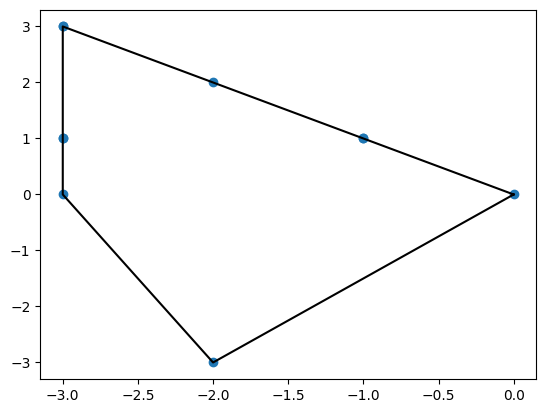

Area of Convex Hull: 9.0
enclosed_area:  9.0


In [6]:
centers_delta, centers = util.get_centers(M_lv, range(0,10), make_plot = False)
centers_delta_neighbouring = centers_delta[1:] - centers_delta[:-1]
enclosed_area = util.centers_enclosed_area(centers_delta, make_plot = True)
print('enclosed_area: ', enclosed_area)

# calculate the major and minor axis of each slice as well as the whole volume

In [8]:
from skimage.measure import label, regionprops
# per slice:
axis_len = []
for z in range(0, M_lv.shape[-1]):
    img_slice = M_lv[:,:,z]
    major, minor = util.major_minor_axis_len(img_slice)
    axis_len.append([major, minor])
major, _ = util.major_minor_axis_len(M_lv) # 3D
axis_len.append([major, 10])
axis_len = np.asarray(axis_len)


# get skeleton

In [98]:
patient_index = 0

ID_0692 1 8
phi_angle:  88.13972892507529


<Figure size 800x400 with 0 Axes>

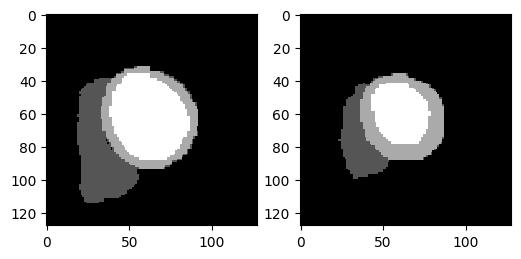

In [99]:
# load data
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES_by_visual'].values[0].astype(int)
print(patient_id, ED,ES)


seg_ed = nb.load(os.path.join(main_path,'results/geometry/', patient_id, 'SAX_ED_seg_for_geometry.nii.gz')).get_fdata()
seg_es = nb.load(os.path.join(main_path,'results/geometry/', patient_id, 'SAX_ES_seg_for_geometry.nii.gz')).get_fdata()


# rotate the data
plt.figure(figsize=(8,4))
insertion_points = np.load(os.path.join(main_path, 'results/strain', patient_id, 'insertion_points.npy'))
insertion_p1 = insertion_points[0,:]
insertion_p2 = insertion_points[1,:]

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(seg_ed, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)


rotate_f = myocardial_strain_zc.Rotate_data(seg_ed, seg_ed, seg_ed, insertion_p1, insertion_p2, non_slice_num = np.arange(0,10))
_,_,seg_ed_rot, ID = rotate_f.rotate_orientation(for_visualization = True)

rotate_f = myocardial_strain_zc.Rotate_data(seg_es, seg_es, seg_es, insertion_p1, insertion_p2, non_slice_num = np.arange(0,10))
_,_,seg_es_rot, ID = rotate_f.rotate_orientation(for_visualization = True)

plt.figure(figsize=(6,3))
plt.subplot(121); plt.imshow(seg_ed_rot[:,:,3], cmap='gray')
plt.subplot(122); plt.imshow(seg_es_rot[:,:,3], cmap='gray')
plt.show()

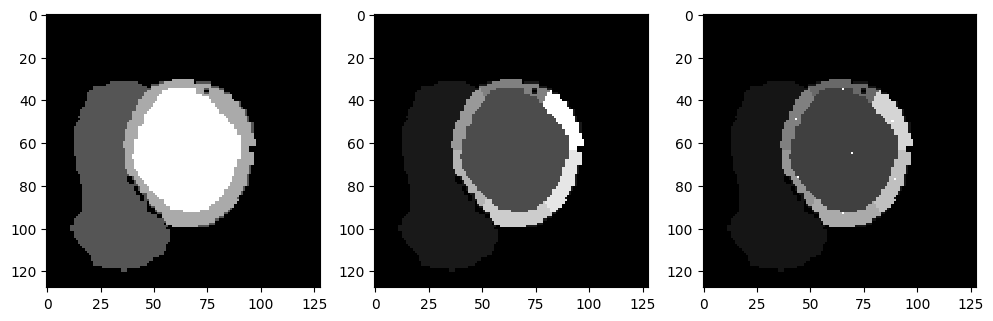

In [100]:
# get center for each AHA segment
aha_center_extractor = myocardial_strain_zc.Find_AHA_segment_centers(seg_ed_rot)
E_aha_ed = aha_center_extractor.assign_different_values_for_each_aha()
aha_center_list_int_ed, aha_center_list_decimals_ed, E_aha_w_centers_ed = aha_center_extractor.find_aha_segment_centers(E_aha_ed)


# get centerline
slice_center_list_int_ed = np.zeros([10,3])
slice_center_list_decimals_ed = np.zeros([10,3])

for slice_n in range(0,10):
    E_slice = np.copy(seg_ed_rot[:,:,slice_n]) == 2
    center_specific_slice = center_of_mass(E_slice)
    center_x = center_specific_slice[0]
    center_y =  center_specific_slice[1]

    if np.isnan(center_x):
        continue

    slice_center_list_int_ed[slice_n, 0] = int(np.round(center_x))
    slice_center_list_int_ed[slice_n, 1] = int(np.round(center_y))
    slice_center_list_int_ed[slice_n, 2] = slice_n

    slice_center_list_decimals_ed[slice_n, 0] = center_x
    slice_center_list_decimals_ed[slice_n, 1] = center_y
    slice_center_list_decimals_ed[slice_n, 2] = slice_n

non_zero_rows = ~np.all(slice_center_list_decimals_ed == 0, axis=1)
slice_center_list_decimals_ed = slice_center_list_decimals_ed[non_zero_rows,:]
slice_center_list_int_ed = slice_center_list_int_ed[non_zero_rows,:]


for slice_center in slice_center_list_int_ed:
    E_aha_w_centers_ed[int(slice_center[0]), int(slice_center[1]), int(slice_center[2])] = 12


plt.figure(figsize=(12,4))
slice_n = 1
plt.subplot(131); plt.imshow(seg_ed_rot[:,:,slice_n], cmap='gray')
plt.subplot(132); plt.imshow(E_aha_ed[:,:,slice_n], cmap='gray')
plt.subplot(133); plt.imshow(E_aha_w_centers_ed[:,:,slice_n], cmap='gray')

In [101]:
# repeat for ES
aha_center_extractor = myocardial_strain_zc.Find_AHA_segment_centers(seg_es_rot)
E_aha_es = aha_center_extractor.assign_different_values_for_each_aha()
aha_center_list_int_es, aha_center_list_decimals_es, E_aha_w_centers_es = aha_center_extractor.find_aha_segment_centers(E_aha_es)

# get centerline
slice_center_list_int_es = np.zeros([10,3])
slice_center_list_decimals_es = np.zeros([10,3])

for slice_n in range(0,10):
    E_slice = np.copy(seg_es_rot[:,:,slice_n]) == 2
    center_specific_slice = center_of_mass(E_slice)
    center_x = center_specific_slice[0]
    center_y =  center_specific_slice[1]

    if np.isnan(center_x):
        continue

    slice_center_list_int_es[slice_n, 0] = int(np.round(center_x))
    slice_center_list_int_es[slice_n, 1] = int(np.round(center_y))
    slice_center_list_int_es[slice_n, 2] = slice_n

    slice_center_list_decimals_es[slice_n, 0] = center_x
    slice_center_list_decimals_es[slice_n, 1] = center_y
    slice_center_list_decimals_es[slice_n, 2] = slice_n

non_zero_rows = ~np.all(slice_center_list_decimals_es == 0, axis=1)
slice_center_list_decimals_es = slice_center_list_decimals_es[non_zero_rows,:]
slice_center_list_int_es = slice_center_list_int_es[non_zero_rows,:]

/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning:

invalid value encountered in double_scalars



In [103]:
aha_center_list_int = [aha_center_list_int_ed, aha_center_list_int_es]
aha_center_list_decimals = [aha_center_list_decimals_ed, aha_center_list_decimals_es]
slice_center_list_int = [slice_center_list_int_ed, slice_center_list_int_es]
slice_center_list_decimals = [slice_center_list_decimals_ed, slice_center_list_decimals_es]

In [102]:
def add_trace(fig, aha_center_list_int, aha_center_list_decimals, slice_center_list_int, slice_center_list_decimals, pick, row = None, column = None):
    trace = []
    for i in range(0,  aha_center_list_decimals[pick].shape[0]):
        z_value = int(aha_center_list_int[pick][i, 2])
        row_index_in_centerline = np.where(slice_center_list_int[pick][:, 2] == z_value)[0]
        aha_point = aha_center_list_decimals[pick][i,:].reshape(1,-1)
        center_point = slice_center_list_decimals[pick][row_index_in_centerline,:][0].reshape(1,-1)

        # cancatenate these two points into two rows
        x2 = np.concatenate((aha_point, center_point), axis = 0)
        if row is None:
            fig.add_trace(go.Scatter3d(x=x2[:, 0], y=x2[:, 1], z=abs(x2[:, 2] - 9), mode='lines+markers', marker=dict(size=5), line=dict(color='red')))
        else:
            fig.add_trace(go.Scatter3d(x=x2[:, 0], y=x2[:, 1], z=abs(x2[:, 2] - 9), mode='lines+markers', marker=dict(size=5), line=dict(color='red')), row=row, col=column)
        # trace.append(ttrace)

    # Extract x, y, z coordinates for centerline
    x1, y1, z1 = slice_center_list_decimals[pick][:, 0], slice_center_list_decimals[pick][:, 1], abs(slice_center_list_decimals[pick][:, 2] - 9)
    if row is None:
        fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1, mode='lines+markers', marker=dict(size=5), line=dict(color='blue')))
    else:
        fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1, mode='lines+markers', marker=dict(size=5), line=dict(color='blue')), row=row, col=column)
    return fig
   


In [75]:
# # single plot

# # trace = add_trace(aha_center_list_int, aha_center_list_decimals, slice_center_list_int, slice_center_list_decimals, pick = 1)

# # Create a figure and add the traces
# fig = go.Figure()
# fig = add_trace(fig, aha_center_list_int, aha_center_list_decimals, slice_center_list_int, slice_center_list_decimals, pick = 1)

# # Set layout options and z-axis ticks
# fig.update_layout(scene=dict(xaxis=dict(range=[0,128]), yaxis=dict(range=[0,128]), zaxis=dict(range=[-1, 10], tickvals=list(range(-1, 11)))),
#                   scene_aspectmode='manual',  # To fix the aspect ratio
#                   width=800, height=800,
#                   showlegend=False)

# # Show the plot
# fig.show()


In [104]:
# plot ED and ES side by side
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])
fig = add_trace(fig, aha_center_list_int, aha_center_list_decimals, slice_center_list_int, slice_center_list_decimals, pick = 0, row = 1, column = 1)
fig = add_trace(fig, aha_center_list_int, aha_center_list_decimals, slice_center_list_int, slice_center_list_decimals, pick = 1, row = 1, column = 2)

# Update layout options and z-axis ticks for both subplots
fig.update_layout(width=1200, height=600, showlegend=False, scene_aspectmode='manual')

# Update x-axis and y-axis ranges for both subplots individually
fig.update_scenes(xaxis=dict(range=[0, 128]), yaxis=dict(range=[0, 128]),  zaxis=dict(range=[-1, 10], tickvals=list(range(-1, 11))),  row=1, col=1)
fig.update_scenes(xaxis=dict(range=[0, 128]), yaxis=dict(range=[0, 128]), zaxis=dict(range=[-1, 10], tickvals=list(range(-1, 11))),row=1, col=2)

fig.update_scenes(
    camera=dict(center=dict(x=0, y=0, z=-0.1), eye=dict(x=1.25, y=1.25, z=0.7)),  # Subplot 1 zoomed in
    row=1, col=1
)
fig.update_scenes(
    camera=dict(center=dict(x=0, y=0, z=-0.1), eye=dict(x=1.25, y=1.25, z=0.7)),  # Subplot 1 zoomed in
    row=1, col=2
)


fig.update_layout(scene=dict(
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    zaxis=dict(title='Z-axis'),
))

fig.update_layout(scene2=dict(
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    zaxis=dict(title='Z-axis'),
))
# Show the plot
fig.show()